In [2]:
import os
import gc
import numpy as np
import pandas as pd

import ast
import re, string
from sklearn.metrics import f1_score, roc_auc_score
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

/home/kranthi/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/kranthi/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/kranthi/anaconda3/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
def get_data():
    train = pd.read_csv("../data/v2/train_ne.csv")
    test = pd.read_csv("../data/test_ne_imputed.csv")
    print("Train Shape : {}\nTest Shape :  {}".format(train.shape, test.shape))
    
    train = train[['fold_id', 'title', 'description', 'text', 'category', 'source']]
    test = test[['title', 'description', 'text', 'category']]
    train.dropna(inplace=True)
    
    return train, test

In [23]:
train, test = get_data()
train.head()

Train Shape : (1199998, 6)
Test Shape :  (92, 5)


,fold_id,title,description,text,category,source
0,1,ziczac black red euro 44,clothing related products b2c shoes shoe laces,ziczac black red euro 44 clothing related prod...,R,valid
1,1,9x9 resista 484938,publishing printing printing services,9x9 resista 484938 publishing printing printin...,S,train
2,1,halle pant short inseam 013049561d0010001 02,clothing related products b2c general,halle pant short inseam 013049561d0010001 02 c...,R,train
3,1,harry houser travel expenses meals,security personnel,harry houser travel expenses meals security pe...,S,train
4,1,tee time 740078609 greens fee composite,admissions green fees privately owned golf course,tee time 740078609 greens fee composite admiss...,R,valid


In [24]:
K = 6

#### LabelEncoding Target

In [25]:
target = 'category'

le = LabelEncoder()
train[target] = le.fit_transform(train[target].values)
test[target] = le.transform(test[target].values)

y = train[target].values
y_test = test[target].values

print(le.classes_)

['R' 'S']


In [26]:
# Splitter
def splitter(data, feat, k=K):
    
    data_v1 = data[data['fold_id'] == k].copy()
    data_v1.reset_index(drop=True, inplace=True)
    
    train_set = data_v1[data_v1['source'] == 'train'].copy()
    valid_set = data_v1[data_v1['source'] == 'valid'].copy()
    train_set.reset_index(drop=True, inplace=True)
    valid_set.reset_index(drop=True, inplace=True)
    
    del data_v1
    gc.collect()
    
#     print(train_set.shape, valid_set.shape)
    
    return train_set[feat].values, valid_set[feat].values, train_set['category'].values, valid_set['category'].values

### Baseliner Function to evaluate : 

In [27]:
def eval_t(y_pred):
    return f1_score(y_test, y_pred)

def baseliner(X_train, X_valid, y_train, y_valid, X_test, cv=3, metric='f1'):
    print("Baseliner Models\n")
    eval_dict = {}
    models = [LogisticRegression(), GaussianNB(), lgb.LGBMClassifier(), RandomForestClassifier(),
              DecisionTreeClassifier(), ExtraTreeClassifier()
             ]
    # xgb.XGBClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier() 
    print("Model Name \t | Train \t | Valid \t | Test ") #    | \t TRN   | \t  VAL
    print("--" * 30)   
    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}
        
        model.fit(X_train, y_train)
        train_f1 = f1_score(y_train, model.predict(X_train))
        valid_f1 = f1_score(y_valid, model.predict(X_valid))
        test_f1 = eval_t(model.predict(X_test))
        
        eval_dict[model_name]['train'] = train_f1
        eval_dict[model_name]['valid'] = valid_f1
        eval_dict[model_name]['test'] = test_f1
        
        print("%s \t | %.4f \t | %.4f \t | %.4f \t " % (
            model_name[:12], eval_dict[model_name]['train'], eval_dict[model_name]['valid'], eval_dict[model_name]['test']))

### Meta Features

In [28]:
import string
punctuation = string.punctuation
swen = stopwords.words('english')

def text_feats(data, textcols):
    # Text Features
    for cols in textcols:
        data[cols + '_char_count'] = data[cols].apply(len) # Character Count
#         print('_char_count')
        data[cols + '_num_words'] = data[cols].apply(lambda x: len(x.split())) # Count number of Words
#         print('_num_words')
        data[cols + '_word_density'] = data[cols + '_char_count'] / (data[cols + '_num_words'] + 1) # Word Density
#         print('_word_density')
        data[cols + '_num_unique_words'] = data[cols].apply(lambda x: len(set(w for w in x.split()))) # Number of unique Words
#         print('_num_unique_words')
        data[cols + '_words_vs_unique'] = data[cols + '_num_unique_words'] / data[cols + '_num_words'] * 100 # Word vs Unique Words (Counts)
#         print('_words_vs_unique')
        data[cols + '_punctuation_count'] = data[cols].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) # Count of Punctuation
#         print('_punctuation_count')
        data[cols + '_title_word_count'] = data[cols].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])) # Count of Titles
#         print('_title_word_count')
        data[cols + '_upper_case_word_count'] = data[cols].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()])) # Upper Case Word Count
#         print('_upper_case_word_count')
        data[cols + '_stopword_count'] = data[cols].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in swen]))
        # print('_stopword_count')

    return data

In [29]:
from collections import Counter
from itertools import chain

In [30]:
%%time

r_texts = train['text'][train[target] == 0].apply(lambda x: x.split()).values.tolist()
tokens_flat = list(chain.from_iterable(r_texts))
r_vocab = Counter(tokens_flat)

s_texts = train['text'][train[target] == 1].apply(lambda x: x.split()).values.tolist()
tokens_flat = list(chain.from_iterable(s_texts))
s_vocab = Counter(tokens_flat)

CPU times: user 10.5 s, sys: 580 ms, total: 11 s
Wall time: 11 s


In [31]:
r_vocab.most_common(10)

[('line', 259901),
 ('products', 258343),
 ('clothing', 246154),
 ('related', 245576),
 ('item', 244110),
 ('variant', 242948),
 ('b2c', 237465),
 ('general', 145159),
 ('order', 119073),
 ('download', 109568)]

In [32]:
s_vocab.most_common(10)

[('services', 225190),
 ('software', 215551),
 ('1', 139398),
 ('website', 116649),
 ('service', 114176),
 ('com', 92970),
 ('server', 90537),
 ('cloud', 86666),
 ('hosted', 86326),
 ('state', 84221)]

In [33]:
r_most_common_words = ['line', 'products', 'clothing', 'related', 'item', 'variant', 'b2c', 'general', 'order', 'download']
s_most_common_words = ['services', 'software', 'website', 'service', 'com', 'server', 'cloud', 'hosted', 'state']

def calc_token_count(X, token):
    return X.count(token)

In [34]:
for cat in [r_most_common_words, s_most_common_words]:
    for col in cat:
        train[col + "_count"] = train['text'].apply(lambda x: calc_token_count(x, col)) # progress_apply
        test[col + "_count"] = test['text'].apply(lambda x: calc_token_count(x, col)) # progress_apply

In [35]:
%%time

train = text_feats(train, ['text'])
test = text_feats(test, ['text'])

CPU times: user 1min 43s, sys: 416 ms, total: 1min 43s
Wall time: 1min 43s


In [41]:
feat = train.columns.tolist()
feat.remove('fold_id')
feat.remove('title')
feat.remove('description')
feat.remove('text')
feat.remove('category')
feat.remove("source")

print(f"Legnth of meta features : {len(feat)}")

Legnth of meta features : 28


In [43]:
# train_orig = train.copy()
# train = train_orig.copy()
# train = train[train['fold_id'] == np.random.choice(train['fold_id'].unique())]
# print(train.shape)

In [44]:
X_train, X_valid, y_new_train, y_new_valid = splitter(train, feat)
print(X_train.shape, X_valid.shape, y_new_train.shape, y_new_valid.shape)

(99372, 28) (20592, 28) (99372,) (20592,)


In [45]:
baseliner(X_train, X_valid, y_new_train, y_new_valid, test[feat])

# Baseliner Models

# Model Name 	 |   CV 	 | Test 
# ------------------------------------------------------------
# LogisticRegr 	 | 0.9340 	 | 0.7723 	 
# GaussianNB 	 | 0.8857 	 | 0.7115 	 
# LGBMClassifi 	 | 0.9591 	 | 0.7593 	 
# RandomForest 	 | 0.9584 	 | 0.7179 	 
# DecisionTree 	 | 0.9567 	 | 0.6111 	 
# ExtraTreeCla 	 | 0.9565 	 | 0.7520 	

Baseliner Models

Model Name 	 | Train 	 | Valid 	 | Test 
------------------------------------------------------------
LogisticRegr 	 | 0.9430 	 | 0.9063 	 | 0.7629 	 
GaussianNB 	 | 0.8825 	 | 0.8951 	 | 0.7048 	 
LGBMClassifi 	 | 0.9640 	 | 0.9242 	 | 0.7339 	 
RandomForest 	 | 0.9739 	 | 0.8416 	 | 0.6903 	 
DecisionTree 	 | 0.9745 	 | 0.8560 	 | 0.6727 	 
ExtraTreeCla 	 | 0.9745 	 | 0.8119 	 | 0.6903 	 


### Boosting Utilities

In [46]:
threshold = 0.5

def f1_lgb(y_hat, data):
    y_true = data.get_label()
    y_hat[y_hat < threshold] = 0
    y_hat[y_hat >= threshold] = 1
    
    return 'f1_score', f1_score(y_true, y_hat), True

def f1_xgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred[y_pred < threshold] = 0
    y_pred[y_pred >= threshold] = 1
    
    return 'f1_score', f1_score(y_true, y_pred)

def lgb_model(trainX, validX, trainY, validY, X_test):
    evals_result = {}
#     trainX, trainY = train_set
#     validX, validY = valid_set
#     trainX, validX, trainY, validY = splitter(train)
    print("LGB Model")
    lgb_train_set = lgb.Dataset(trainX, label=trainY)
    lgb_valid_set = lgb.Dataset(validX, label=validY)

    MAX_ROUNDS = 2000
    lgb_params = {
        "boosting": 'gbdt',  # "dart",
        "learning_rate": 0.01,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": "binary",
    }

    lgb_model = lgb.train(
        lgb_params,
        train_set=lgb_train_set,
        valid_sets=[lgb_train_set, lgb_valid_set],
        early_stopping_rounds=50,
        verbose_eval=100,
        evals_result=evals_result,
        feval=f1_lgb
    )

    lgb.plot_importance(lgb_model, figsize=(24, 24))
    lgb.plot_metric(evals_result, metric='f1_score')
    
    preds = lgb_model.predict(X_test)
    pred_probs = preds.copy()
    preds[preds >= threshold] = 1
    preds[preds < threshold] = 0
    
    test_f1 = eval_t(preds)
    print("Test Score : {}".format(test_f1))
    
    return lgb_model, pred_probs

def xgb_model(X_train, X_valid, y_train, y_valid, X_test):

    MAX_ROUNDS=2000
    early_stopping_rounds=50
    params = {
        'booster': 'gbtree', # dart
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'learning_rate': 0.1,
        'num_round': MAX_ROUNDS,
        'max_depth': 8,
        'seed': 13,
        'nthread': -1
    }
    
#     X_train, y_train = train_set
#     X_valid, y_valid = valid_set
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    model = xgb.train(
        params,
        dtrain,
        evals=watchlist,
        num_boost_round=MAX_ROUNDS,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=50,
        feval=f1_xgb,
        maximize=True
    )
    print("Best Iteration :: ", model.best_iteration)

    # Plotting Importances
    fig, ax = plt.subplots(figsize=(24, 24))
    xgb.plot_importance(model, height=0.4, ax=ax)
    preds = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
    pred_probs = preds.copy()
    preds[preds >= threshold] = 1
    preds[preds < threshold] = 0
    
    test_f1 = eval_t(preds)
    print("Test Score : {}".format(test_f1))
    
    return model, , pred_probs

def feature_order(feat, model):
    feat_imp = pd.DataFrame(model.feature_importances_, index=feat)
    feat_imp.reset_index(inplace=True)
    feat_imp.columns = ['columns', 'importance']

    feat_imp = feat_imp.iloc[feat_imp['importance'].sort_values(ascending=False).index]

    return feat_imp, feat_imp['columns'].values.tolist()

LGB Model
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.273172	training's f1_score: 0.951506	valid_1's binary_logloss: 0.274843	valid_1's f1_score: 0.949834
[200]	training's binary_logloss: 0.157365	training's f1_score: 0.95466	valid_1's binary_logloss: 0.160339	valid_1's f1_score: 0.953355
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.154154	training's f1_score: 0.954654	valid_1's binary_logloss: 0.157175	valid_1's f1_score: 0.953517
Test Score : 0.7047619047619048


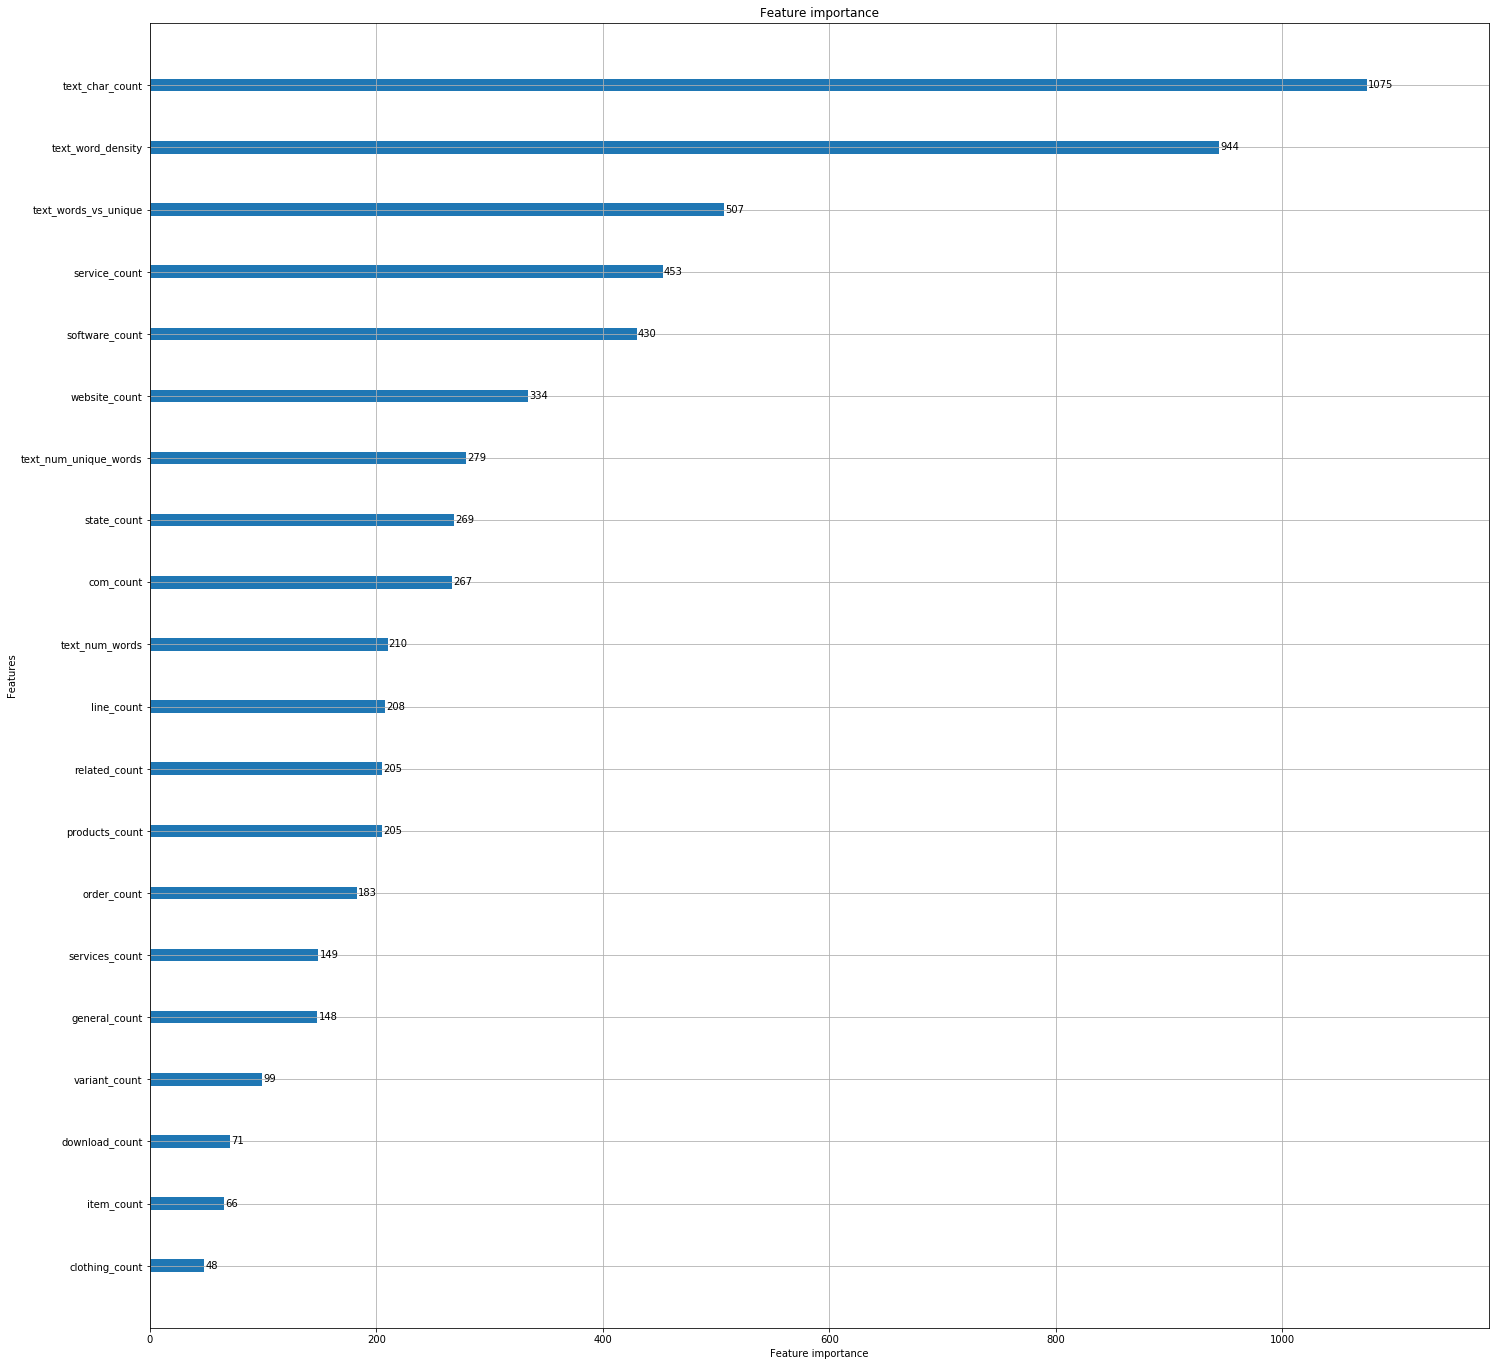

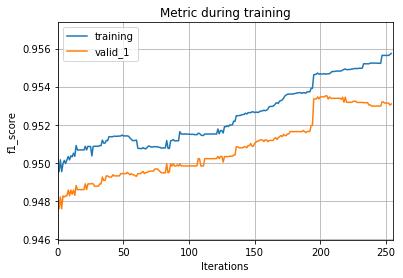

In [21]:
lgbM, lgb_preds = lgb_model(X_train, X_valid, y_new_train, y_new_valid, test[feat])

(101960, 28) (17993, 28) (101960,) (17993,)
[22:41:17] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-error:0.08175	valid-error:0.08275	train-f1_score:0.91150	valid-f1_score:0.91000
Multiple eval metrics have been passed: 'valid-f1_score' will be used for early stopping.

Will train until valid-f1_score hasn't improved in 50 rounds.
[50]	train-error:0.04192	valid-error:0.04491	train-f1_score:0.95716	valid-f1_score:0.95396
[100]	train-error:0.03819	valid-error:0.04246	train-f1_score:0.96106	valid-f1_score:0.95660
[150]	train-error:0.03596	valid-error:0.04174	train-f1_score:0.96345	valid-f1_score:0.95740
[200]	train-error:0.03405	valid-error:0.04079	train-f1_score:0.96545	valid-f1_score:0.95847
[250]	tra

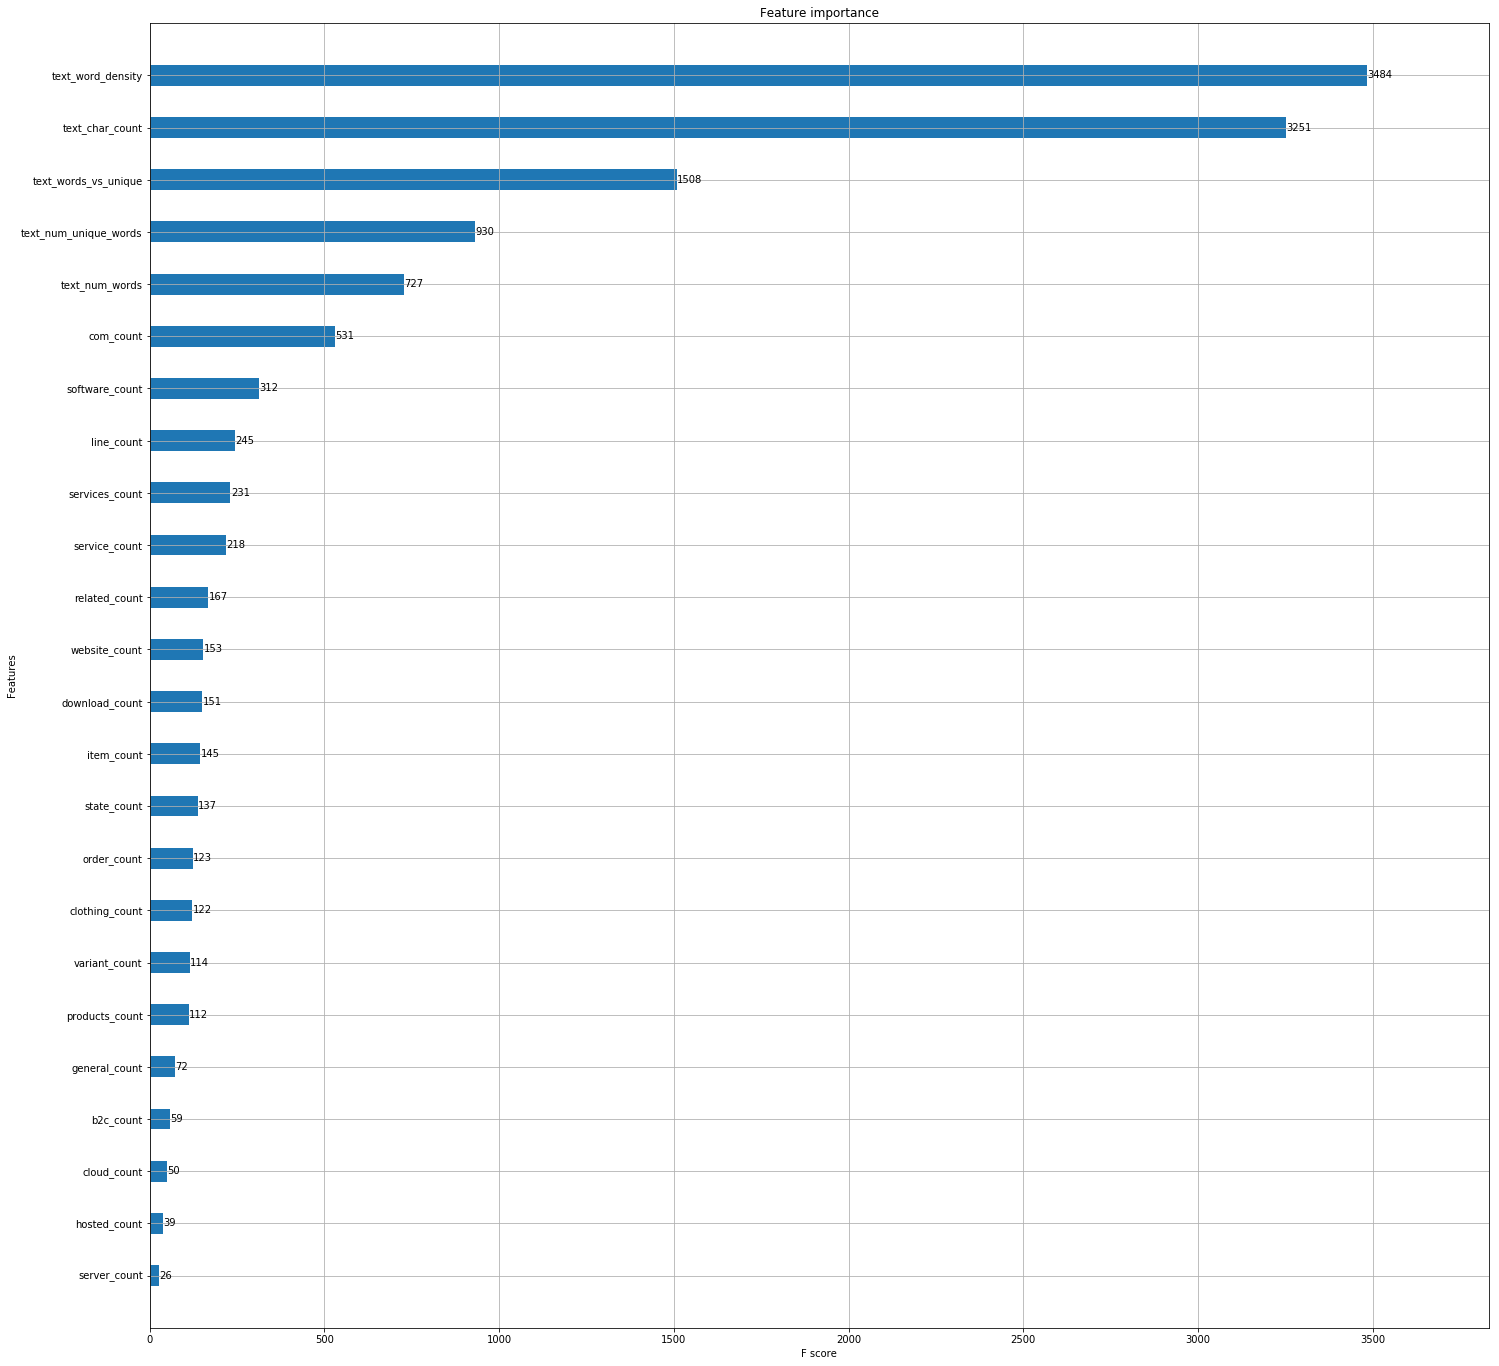

In [22]:
xgbM, xgb_preds = xgb_model(X_train, X_valid, y_new_train, y_new_valid, test[feat])

## Evaluation

Even though the f1 is not as great as BOW Models but this acts as a great and a very deployable baseline.

### Confusion Matrix + Understanding Evaluation

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

def plot_classification_report(model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    T = 0.44
    preds = model.predict_proba(X_test)[:, 1]
    pred_probs = preds.copy()
    preds[preds >= T] = 1
    preds[preds < T] = 0
    
    cm = confusion_matrix(y_test, preds)
    print("Classification Report")
    print(classification_report(y_test, preds))
    class_names = ["R", "S"]  # name  of classes

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return pred_probs

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.83      0.71        35
           1       0.87      0.68      0.76        57

    accuracy                           0.74        92
   macro avg       0.74      0.76      0.74        92
weighted avg       0.77      0.74      0.74        92



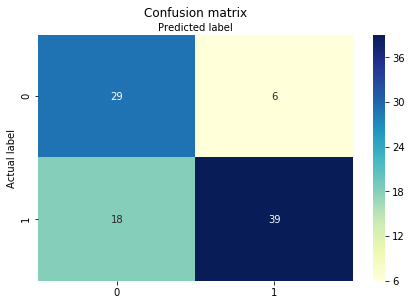

In [50]:
pred_probs = plot_classification_report(LogisticRegression(), X_train, test[feat], y_new_train, y_test)

It seems our model is still having problems and have high False Negatives just as BOW models.

## Conclusion 

### BEST F1 Score : 0.7629 (Logistic Regression)**

### Even though the f1 here is lower than Previous Modelling techniquest these Meta Features may help in making a very fast and deployable solution.